# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель проекта:**

Разработать модель предсказывающая цену автомобиля для приложения для привлечения новых клиентов. (RMSE < 2500)

**Описание данных**

Признаки

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import re
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
import lightgbm
import catboost
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv("/datasets/autos.csv")
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [4]:
sum(df.duplicated())

4

Проблемы, необходимые решить на этапе прежобработки данных:
- пропуски
- дупликаты
- наличие неинформативных признаков ('PostalCode', 'NumberOfPictures', 'DateCrawled')

Кроме пропущенных значений и дупликатов, в данных имеются странные значения, корректность которых критчески важны для обучения модели:
- Price (целевой признак) = 0
- Power = 0
- RegistrationYear (1000, 9999)

In [5]:
df = df.drop(columns=['PostalCode', 'NumberOfPictures', 'DateCrawled', "DateCreated", "LastSeen"])
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [6]:
sum(df.duplicated())

27543

In [7]:
df = df.drop_duplicates()

In [8]:
df[df["Price"] == 0]["Price"].count()

9387

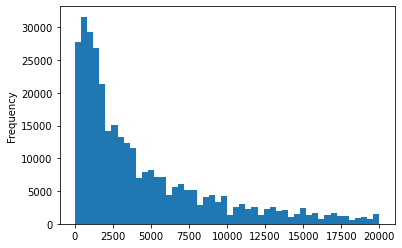

In [9]:
df["Price"].plot(kind="hist", bins=50);

In [10]:
df = df[df["Price"] > 0]

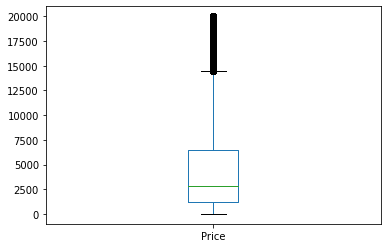

In [11]:
df["Price"].plot(kind="box");

In [12]:
df["RegistrationMonth"].value_counts()

3     31168
0     31131
6     28455
4     26714
5     26329
7     24741
10    23452
12    21804
11    21606
9     21482
1     20979
8     20347
2     19231
Name: RegistrationMonth, dtype: int64

In [13]:
df[(df["RegistrationYear"] > 2022) | (df["RegistrationYear"] < 1900)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
12946,49,NaN,5000,NaN,0,golf,5000,12,NaN,volkswagen,NaN
15870,1700,NaN,3200,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN
16062,190,NaN,1000,NaN,0,mondeo,5000,0,NaN,ford,NaN
17271,700,NaN,9999,NaN,0,other,10000,0,NaN,opel,NaN
17346,6500,NaN,8888,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN
...,...,...,...,...,...,...,...,...,...,...,...
338829,50,NaN,3000,NaN,3000,golf,100000,6,NaN,volkswagen,yes
340759,700,NaN,1600,manual,1600,a3,150000,4,petrol,audi,no
341791,1,NaN,3000,NaN,0,zafira,5000,0,NaN,opel,NaN
348830,1,NaN,1000,NaN,1000,NaN,150000,0,NaN,sonstige_autos,NaN


In [14]:
df = df[~((df["RegistrationYear"] > 2022) | (df["RegistrationYear"] < 1900))]
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


In [15]:
df["RegistrationYear"] = df["RegistrationYear"] + (df["RegistrationMonth"]/12).round(2)
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993.00,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011.42,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004.67,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001.50,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008.58,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354362,3200,sedan,2004.42,manual,225,leon,150000,5,petrol,seat,yes
354365,2200,NaN,2005.08,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN
354366,1199,convertible,2000.25,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996.25,manual,102,transporter,150000,3,gasoline,volkswagen,no


In [16]:
df = df.drop(columns=["RegistrationMonth"])

In [17]:
category_list = ['Model', 'Brand', 'VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']
numeric_list = ['RegistrationYear', 'Power', 'Kilometer']

In [18]:
# оценим кол-во наблюдений с множеством пропущенных значений, вкл. критически важный "Power", удалим их 
df[(df["FuelType"].isna()) & (df["Gearbox"].isna()) & (df["VehicleType"].isna()) & 
   (df["NotRepaired"].isna()) & (df["Power"]==0)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
94,8390,NaN,2009.00,NaN,0,insignia,150000,NaN,opel,NaN
130,3390,NaN,2000.17,NaN,0,3er,150000,NaN,bmw,NaN
306,200,NaN,2009.00,NaN,0,NaN,10000,NaN,sonstige_autos,NaN
355,1050,NaN,2018.00,NaN,0,golf,150000,NaN,volkswagen,NaN
409,4500,NaN,2016.83,NaN,0,fox,60000,NaN,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...
354128,400,NaN,2000.00,NaN,0,twingo,150000,NaN,renault,NaN
354162,1500,NaN,1995.00,NaN,0,NaN,150000,NaN,volkswagen,NaN
354226,9000,NaN,2008.00,NaN,0,1er,125000,NaN,bmw,NaN
354305,3500,NaN,1995.00,NaN,0,polo,150000,NaN,volkswagen,NaN


In [19]:
df = df[~((df["FuelType"].isna()) & (df["Gearbox"].isna()) & (df["VehicleType"].isna()) & 
   (df["NotRepaired"].isna()) & (df["Power"]==0))]


In [20]:
df.isna().sum()

Price                   0
VehicleType         28485
RegistrationYear        0
Gearbox             12016
Power                   0
Model               15604
Kilometer               0
FuelType            24651
Brand                   0
NotRepaired         58266
dtype: int64

In [21]:
for category in category_list:
    df[category] = df[category].fillna("unknown")

In [22]:
power_tab = df.groupby('Model')['Power'].median()

In [23]:
def ft_power(data):
    if data['Power'] == 0:
        m = data["Model"]
        return power_tab[m]
    else:
        return data['Power']

In [24]:
df["Power"] = df.apply(ft_power, axis=1)

In [25]:
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

In [26]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,313719.000000,313719.000000,313719.000000,313719.000000
mean,4567.110376,2003.658329,122.102923,128575.747723
std,4525.013338,7.367070,191.396820,37110.032005
min,1.000000,1910.000000,0.000000,5000.000000
25%,1200.000000,1999.420000,75.000000,125000.000000
50%,2899.000000,2003.670000,109.000000,150000.000000
75%,6500.000000,2008.170000,143.000000,150000.000000
max,20000.000000,2020.000000,20000.000000,150000.000000


In [27]:
# еще как-то остались Power=0, удалим их
df[df["Power"]==0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
3338,199,unknown,1995.00,manual,0.0,samara,100000,petrol,lada,unknown
26625,200,unknown,2016.00,manual,0.0,samara,150000,petrol,lada,unknown
42665,300,small,1997.25,manual,0.0,samara,50000,petrol,lada,yes
69358,99,unknown,1995.00,manual,0.0,samara,125000,petrol,lada,unknown
75177,249,unknown,1985.00,manual,0.0,samara,125000,petrol,lada,unknown
150050,650,wagon,2007.67,manual,0.0,samara,125000,petrol,lada,unknown
234296,3800,wagon,1978.00,manual,0.0,serie_1,30000,gasoline,land_rover,unknown
353555,2199,unknown,2016.00,manual,0.0,samara,70000,unknown,lada,no


In [28]:
df = df[~(df["Power"]==0)]

### Вывод
- избавились от дупликатов и неинформативных признаков ('PostalCode', 'NumberOfPictures', 'DateCrawled', 'RegistrationMonth')
- удалили наблюденя с осутствующими или неадекватными, но критически важными признаками (цена=0, регистрация не в 20-21 веках, мощность=0 и большое кол-во пропусков)
- заполнили пропуски в оставшихся наблюдениях

In [29]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unknown,1993.00,manual,100.0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011.42,manual,190.0,unknown,125000,gasoline,audi,yes
2,9800,suv,2004.67,auto,163.0,grand,125000,gasoline,jeep,unknown
3,1500,small,2001.50,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008.58,manual,69.0,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354361,5250,unknown,2017.00,auto,150.0,159,150000,unknown,alfa_romeo,no
354362,3200,sedan,2004.42,manual,225.0,leon,150000,petrol,seat,yes
354366,1199,convertible,2000.25,auto,101.0,fortwo,125000,petrol,smart,no
354367,9200,bus,1996.25,manual,102.0,transporter,150000,gasoline,volkswagen,no


## Обучение моделей

In [30]:
df_ohe = df.copy()
df_ohe = pd.get_dummies(df_ohe, drop_first=True)
df_ohe.info()
df_ohe.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313711 entries, 0 to 354368
Columns: 311 entries, Price to NotRepaired_yes
dtypes: float64(2), int64(2), uint8(307)
memory usage: 103.8 MB


,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,480,1993.00,100.0,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,2011.42,190.0,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004.67,163.0,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001.50,75.0,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008.58,69.0,90000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
df_ohe[numeric_list]

,RegistrationYear,Power,Kilometer
0,1993.00,100.0,150000
1,2011.42,190.0,125000
2,2004.67,163.0,125000
3,2001.50,75.0,150000
4,2008.58,69.0,90000
...,...,...,...
354361,2017.00,150.0,150000
354362,2004.42,225.0,150000
354366,2000.25,101.0,125000
354367,1996.25,102.0,150000


In [32]:
#масштабируем кол-ные признаки
scaler = StandardScaler()
scaler.fit(df_ohe[numeric_list]) 
df_ohe[numeric_list] = scaler.transform(df_ohe[numeric_list])
df_ohe.head()

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,480,-1.446818,-0.115498,0.577303,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,1.053581,0.354727,-0.096378,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,0.137311,0.213659,-0.096378,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,-0.292997,-0.246116,0.577303,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,0.668069,-0.277464,-1.039531,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
df_ohe

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,480,-1.446818,-0.115498,0.577303,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,1.053581,0.354727,-0.096378,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,0.137311,0.213659,-0.096378,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,-0.292997,-0.246116,0.577303,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,0.668069,-0.277464,-1.039531,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,1.811031,0.145738,0.577303,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
354362,3200,0.103375,0.537592,0.577303,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
354366,1199,-0.462676,-0.110273,-0.096378,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
354367,9200,-1.005651,-0.105048,0.577303,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [34]:
X = df_ohe.drop(columns=['Price'])
y = df_ohe['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (235283, 310)
X_test: (78428, 310)


### Linear Regression

In [35]:
%%time
lr = LinearRegression()
lr.fit(X_train, y_train)
predicted = lr.predict(X_test)
print("RMSE of Linear Regression:", mean_squared_error(y_test, predicted, squared=False))

RMSE of Linear Regression: 2840.0591233205782
CPU times: user 24.2 s, sys: 19.1 s, total: 43.3 s
Wall time: 43.3 s


### Random forest

In [36]:
df_oe = df.copy()
df_oe[category_list] = OrdinalEncoder().fit_transform(df_oe[category_list])
df_oe.info()
df_oe.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313711 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             313711 non-null  int64  
 1   VehicleType       313711 non-null  float64
 2   RegistrationYear  313711 non-null  float64
 3   Gearbox           313711 non-null  float64
 4   Power             313711 non-null  float64
 5   Model             313711 non-null  float64
 6   Kilometer         313711 non-null  int64  
 7   FuelType          313711 non-null  float64
 8   Brand             313711 non-null  float64
 9   NotRepaired       313711 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 26.3 MB


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,7.0,1993.00,1.0,100.0,116.0,150000,6.0,38.0,1.0
1,18300,2.0,2011.42,1.0,190.0,227.0,125000,2.0,1.0,2.0
2,9800,6.0,2004.67,0.0,163.0,117.0,125000,2.0,14.0,1.0
3,1500,5.0,2001.50,1.0,75.0,116.0,150000,6.0,38.0,0.0
4,3600,5.0,2008.58,1.0,69.0,101.0,90000,2.0,31.0,0.0


In [37]:
scaler = StandardScaler()
scaler.fit(df_oe[numeric_list]) 
df_oe[numeric_list] = scaler.transform(df_oe[numeric_list])
df_oe.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,7.0,-1.446818,1.0,-0.115498,116.0,0.577303,6.0,38.0,1.0
1,18300,2.0,1.053581,1.0,0.354727,227.0,-0.096378,2.0,1.0,2.0
2,9800,6.0,0.137311,0.0,0.213659,117.0,-0.096378,2.0,14.0,1.0
3,1500,5.0,-0.292997,1.0,-0.246116,116.0,0.577303,6.0,38.0,0.0
4,3600,5.0,0.668069,1.0,-0.277464,101.0,-1.039531,2.0,31.0,0.0


In [38]:
X_oe = df_oe.drop(columns=['Price'])
y_oe = df_oe['Price']
X_train_oe, X_test_oe, y_train_oe, y_test_oe = train_test_split(X_oe, y_oe, test_size=0.25, random_state=42)
print("X_train:", X_train_oe.shape)
print("X_test:", X_test_oe.shape)

X_train: (235283, 9)
X_test: (78428, 9)


In [39]:
%%time
model = RandomForestRegressor(random_state=42)
parametrs = {'n_estimators': (1,50,100), "max_depth" : range (0, 11, 5)}
grid = GridSearchCV(model, parametrs,scoring='neg_root_mean_squared_error', cv=3, verbose=2, n_jobs=-1)
grid.fit(X_train_oe, y_train_oe)
print(grid.best_params_)
print('RMSE of Random forest: {:.2f}'.format(grid.best_score_))
print(grid.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ........................max_depth=0, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=0, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=0, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=0, n_estimators=50; total time=   0.0s
[CV] END .......................max_depth=0, n_estimators=50; total time=   0.0s
[CV] END .......................max_depth=0, n_estimators=50; total time=   0.0s
[CV] END ......................max_depth=0, n_estimators=100; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END ......................max_depth=0, n_estimators=100; total time=   0.0s
[CV] END ......................max_depth=0, n_estimators=100; total time=   0.0s
[CV] END ........................max_depth=5, n_estimators=1; total time=   0.1s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV] END ........................max_depth=5, n_estimators=1; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=1; total time=   0.1s
[CV] END .......................max_depth=5, n_estimators=50; total time=   6.1s
[CV] END .......................max_depth=5, n_estimators=50; total time=   6.1s
[CV] END .......................max_depth=5, n_estimators=50; total time=   7.2s
[CV] END ......................max_depth=5, n_estimators=100; total time=  12.1s
[CV] END ......................max_depth=5, n_estimators=100; total time=  12.2s
[CV] END ......................max_depth=5, n_estimators=100; total time=  12.4s
[CV] END .......................max_depth=10, n_estimators=1; total time=   0.2s
[CV] END .......................max_depth=10, n_estimators=1; total time=   0.3s
[CV] END .......................max_depth=10, n_estimators=1; total time=   0.3s
[CV] END ......................max_depth=10, n_estimators=50; total time=  11.4s
[CV] END ...................

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [           nan            nan            nan -2492.47368616
 -2428.81679503 -2427.79623494 -2108.79501181 -1925.42140756
 -1923.06595068]
  warnings.warn(


{'max_depth': 10, 'n_estimators': 100}
RMSE of Random forest: -1923.07
-1923.065950680237
CPU times: user 3min 12s, sys: 0 ns, total: 3min 12s
Wall time: 3min 14s


In [40]:
%%time
rf = RandomForestRegressor(**grid.best_params_, random_state=42)
rf.fit(X_train_oe, y_train_oe)
predicted = rf.predict(X_test_oe)
print("RMSE of Random forest:", mean_squared_error(y_test_oe, predicted, squared=False))

RMSE of Random forest: 1910.6908709137808
CPU times: user 34.4 s, sys: 0 ns, total: 34.4 s
Wall time: 34.5 s


### CatBoost

In [41]:
%%time

model = catboost.CatBoostRegressor(loss_function='RMSE', verbose=10, thread_count=-1, random_seed=42)

params = {'learning_rate': (0.1, 0.5, 1),
        'depth': (5, 10, 15),
        'iterations' : [50, 100, 200]}

grid = model.grid_search(param_grid=params, X=X_train, y=y_train, verbose=10, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 5913.1158110	test: 5891.8872803	best: 5891.8872803 (0)	total: 77.6ms	remaining: 3.8s
10:	learn: 3152.2810461	test: 3131.7000502	best: 3131.7000502 (10)	total: 338ms	remaining: 1.2s
20:	learn: 2410.1651596	test: 2393.9959569	best: 2393.9959569 (20)	total: 582ms	remaining: 804ms
30:	learn: 2186.9771962	test: 2176.2335732	best: 2176.2335732 (30)	total: 826ms	remaining: 506ms
40:	learn: 2088.9889848	test: 2080.6726697	best: 2080.6726697 (40)	total: 1.06s	remaining: 232ms
49:	learn: 2033.3823915	test: 2026.3372869	best: 2026.3372869 (49)	total: 1.27s	remaining: 0us

bestTest = 2026.337287
bestIteration = 49

0:	loss: 2026.3372869	best: 2026.3372869 (0)	total: 3.19s	remaining: 1m 22s
0:	learn: 4067.3563898	test: 4047.3082701	best: 4047.3082701 (0)	total: 26.6ms	remaining: 1.3s
10:	learn: 2041.8039425	test: 2030.6359887	best: 2030.6359887 (10)	total: 273ms	remaining: 968ms
20:	learn: 1923.7876563	test: 1916.0861705	best: 1916.0861705 (20)	total: 502ms	remaining: 693ms
30:	learn: 186

In [42]:
grid["params"]

{'depth': 10, 'iterations': 200, 'learning_rate': 0.5}

In [43]:
pd.DataFrame(grid["cv_results"]).sort_values(by=['test-RMSE-mean'])

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
194,194,1655.613542,7.540530,1416.471876,2.633349
199,199,1655.633795,7.805669,1412.638404,1.489329
193,193,1655.642631,7.568796,1417.329377,2.862694
197,197,1655.687729,7.568296,1414.119972,1.226461
198,198,1655.690099,7.710089,1413.390659,1.040329
...,...,...,...,...,...
4,4,2009.951340,8.941059,1995.631406,4.031506
3,3,2101.859386,9.342180,2091.329253,7.351345
2,2,2312.891617,7.493393,2304.245469,7.443967
1,1,2773.140596,9.781106,2767.891359,3.412079


In [44]:
%%time

model = catboost.CatBoostRegressor(loss_function='RMSE', **grid['params'], verbose=10, thread_count=-1, random_seed=42)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
print("RMSE of catboost:", mean_squared_error(y_test, predicted, squared=False))

0:	learn: 3084.5514181	total: 67ms	remaining: 13.3s
10:	learn: 1830.5067823	total: 819ms	remaining: 14.1s
20:	learn: 1747.4038894	total: 1.5s	remaining: 12.8s
30:	learn: 1697.2381965	total: 2.18s	remaining: 11.9s
40:	learn: 1660.7478013	total: 2.83s	remaining: 11s
50:	learn: 1633.7481228	total: 3.46s	remaining: 10.1s
60:	learn: 1610.5349476	total: 4.13s	remaining: 9.4s
70:	learn: 1590.2117396	total: 4.79s	remaining: 8.7s
80:	learn: 1574.8423183	total: 5.48s	remaining: 8.05s
90:	learn: 1559.0117276	total: 6.15s	remaining: 7.36s
100:	learn: 1545.0074820	total: 6.8s	remaining: 6.66s
110:	learn: 1532.2830420	total: 7.45s	remaining: 5.97s
120:	learn: 1519.7738415	total: 8.12s	remaining: 5.3s
130:	learn: 1509.3214232	total: 8.79s	remaining: 4.63s
140:	learn: 1497.1520050	total: 9.44s	remaining: 3.95s
150:	learn: 1487.9003437	total: 10.1s	remaining: 3.28s
160:	learn: 1478.9244509	total: 10.8s	remaining: 2.62s
170:	learn: 1470.8932552	total: 11.5s	remaining: 1.94s
180:	learn: 1462.7164874	tota

In [45]:
%%time

model = catboost.CatBoostRegressor(loss_function='RMSE', depth=10, iterations=200, learning_rate=0.1, verbose=10, thread_count=-1, random_seed=42)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
print("RMSE of catboost:", mean_squared_error(y_test, predicted, squared=False))

0:	learn: 4199.8276258	total: 65ms	remaining: 12.9s
10:	learn: 2538.5753199	total: 770ms	remaining: 13.2s
20:	learn: 2082.6002727	total: 1.41s	remaining: 12s
30:	learn: 1920.9216976	total: 2.08s	remaining: 11.3s
40:	learn: 1854.5930479	total: 2.75s	remaining: 10.7s
50:	learn: 1819.5622952	total: 3.38s	remaining: 9.87s
60:	learn: 1795.9630928	total: 4.04s	remaining: 9.2s
70:	learn: 1771.9193030	total: 4.7s	remaining: 8.53s
80:	learn: 1754.0045701	total: 5.4s	remaining: 7.94s
90:	learn: 1739.5942332	total: 6.04s	remaining: 7.24s
100:	learn: 1727.3011869	total: 6.69s	remaining: 6.55s
110:	learn: 1715.8676763	total: 7.31s	remaining: 5.86s
120:	learn: 1704.3112269	total: 7.96s	remaining: 5.19s
130:	learn: 1693.6327284	total: 8.6s	remaining: 4.53s
140:	learn: 1684.5235379	total: 9.24s	remaining: 3.87s
150:	learn: 1675.9064869	total: 9.9s	remaining: 3.21s
160:	learn: 1667.8884608	total: 10.5s	remaining: 2.55s
170:	learn: 1660.8289195	total: 11.2s	remaining: 1.9s
180:	learn: 1653.5511558	total

### LightGBM

In [46]:
%%time

model = lightgbm.LGBMRegressor(metric='rmse', verbose=10, n_jobs=-1, random_state=42) 
model.fit(X_train, y_train, eval_metric='rmse')

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.920033
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.466909
[LightGBM] [Debug] init for col-wise cost 0.380639 seconds, init for row-wise cost 0.398887 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.486846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1108
[LightGBM] [Info] Number of data points in the train set: 235283, number of used features: 295
[LightGBM] [Info] Start training from score 4556.946639
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trai

LGBMRegressor(metric='rmse', random_state=42, verbose=10)

In [47]:
%%time
predicted = model.predict(X_test)
print("RMSE of LightGBM:", mean_squared_error(y_test, predicted, squared=False))

RMSE of LightGBM: 1725.0976281943606
CPU times: user 826 ms, sys: 110 ms, total: 937 ms
Wall time: 976 ms


In [48]:
%%time
model = lightgbm.LGBMRegressor(num_leaves=100, metric='rmse', n_estimators=200, verbose=10, n_jobs=-1, random_state=42) 
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse')

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.920033
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.466909
[LightGBM] [Debug] init for col-wise cost 0.377533 seconds, init for row-wise cost 0.400973 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.506886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1108
[LightGBM] [Info] Number of data points in the train set: 235283, number of used features: 295
[LightGBM] [Info] Start training from score 4556.946639
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 10
[1]	valid_0's rmse: 4207.74
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 12
[2]	valid_0's rmse: 3904.45
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 11
[3]	valid_0's rmse: 3638.34
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 12
[4]	valid_0's rmse: 3405.03
[LightGBM] [D

LGBMRegressor(metric='rmse', n_estimators=200, num_leaves=100, random_state=42,
              verbose=10)

In [49]:
%%time
predicted = model.predict(X_test)
print("RMSE of LightGBM:", mean_squared_error(y_test, predicted, squared=False))

RMSE of LightGBM: 1616.6527511547883
CPU times: user 1.81 s, sys: 83.1 ms, total: 1.89 s
Wall time: 1.83 s


## Анализ моделей

Результаты по итогам обучения моделей:
- RMSE of Linear Regression: 2775.35, Wall time: 24.1 s
- RMSE of Random forest:     1925.05, Wall time: 7min 27s (1ч 12 минут для подбора параметров)
- RMSE of catboost:          1569.93, Wall time: 18.8 s (+ 22 минут для подбора параметров)
- RMSE of LightGBM:          1562.21, Wall time: 35.2 s

In [50]:
%%time
lr = LinearRegression()
lr.fit(X_train, y_train)

CPU times: user 20.1 s, sys: 11.7 s, total: 31.8 s
Wall time: 31.8 s


LinearRegression()

In [51]:
%%time
predicted = lr.predict(X_test)
print("RMSE of Linear Regression:", mean_squared_error(y_test, predicted, squared=False))

RMSE of Linear Regression: 2840.0591233205782
CPU times: user 94.6 ms, sys: 96.1 ms, total: 191 ms
Wall time: 197 ms


In [52]:
%%time
rf.fit(X_train_oe, y_train_oe)

CPU times: user 33.7 s, sys: 23.9 ms, total: 33.7 s
Wall time: 33.7 s


RandomForestRegressor(max_depth=10, random_state=42)

In [53]:
%%time
predicted = rf.predict(X_test_oe)
print("RMSE of Random forest:", mean_squared_error(y_test_oe, predicted, squared=False))

RMSE of Random forest: 1910.6908709137808
CPU times: user 672 ms, sys: 0 ns, total: 672 ms
Wall time: 677 ms


In [54]:
%%time
model = catboost.CatBoostRegressor(loss_function='RMSE', depth=10, iterations=200, learning_rate=0.1, 
                                   verbose=10, thread_count=-1, random_seed=42)
model.fit(X_train, y_train)


0:	learn: 4199.8276258	total: 61.7ms	remaining: 12.3s
10:	learn: 2538.5753199	total: 680ms	remaining: 11.7s
20:	learn: 2082.6002727	total: 1.31s	remaining: 11.2s
30:	learn: 1920.9216976	total: 1.92s	remaining: 10.4s
40:	learn: 1854.5930479	total: 2.52s	remaining: 9.78s
50:	learn: 1819.5622952	total: 3.16s	remaining: 9.23s
60:	learn: 1795.9630928	total: 3.79s	remaining: 8.64s
70:	learn: 1771.9193030	total: 4.42s	remaining: 8.03s
80:	learn: 1754.0045701	total: 5.04s	remaining: 7.41s
90:	learn: 1739.5942332	total: 5.68s	remaining: 6.8s
100:	learn: 1727.3011869	total: 6.4s	remaining: 6.27s
110:	learn: 1715.8676763	total: 7.03s	remaining: 5.64s
120:	learn: 1704.3112269	total: 7.65s	remaining: 4.99s
130:	learn: 1693.6327284	total: 8.26s	remaining: 4.35s
140:	learn: 1684.5235379	total: 8.9s	remaining: 3.72s
150:	learn: 1675.9064869	total: 9.52s	remaining: 3.09s
160:	learn: 1667.8884608	total: 10.1s	remaining: 2.45s
170:	learn: 1660.8289195	total: 10.8s	remaining: 1.83s
180:	learn: 1653.551155

In [55]:
%%time
predicted = model.predict(X_test)
print("RMSE of catboost:", mean_squared_error(y_test, predicted, squared=False))

RMSE of catboost: 1679.7998971344591
CPU times: user 87.7 ms, sys: 2.91 ms, total: 90.6 ms
Wall time: 88.3 ms


In [56]:
%%time
model = lightgbm.LGBMRegressor(num_leaves=100, metric='rmse', n_estimators=200, verbose=10, n_jobs=-1, random_state=42) 
model.fit(X_train, y_train, eval_metric='rmse')

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.920033
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.466909
[LightGBM] [Debug] init for col-wise cost 0.189646 seconds, init for row-wise cost 0.290813 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.301713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1108
[LightGBM] [Info] Number of data points in the train set: 235283, number of used features: 295
[LightGBM] [Info] Start training from score 4556.946639
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 12
[LightGBM] [Deb

LGBMRegressor(metric='rmse', n_estimators=200, num_leaves=100, random_state=42,
              verbose=10)

In [57]:
%%time
predicted = model.predict(X_test)
print("RMSE of LightGBM:", mean_squared_error(y_test, predicted, squared=False))

RMSE of LightGBM: 1616.6527511547883
CPU times: user 1.88 s, sys: 7.48 ms, total: 1.88 s
Wall time: 1.91 s


In [60]:
d = {'model': ["Linear Regression", "Random forest", "Catboost", "LightGBM"], 
     'RMSE': [2840.06, 1910.69, 1679.80, 1616.65],
     'time to fit': ["31.8 s", "33.7 s", "14.6 s", "3min 59s"],
     'time to predict': ["0.197 s", "0.677 s", "0.883 s", "1.91 s"],
    }
df = pd.DataFrame(data=d)
df

,model,RMSE,time to fit,time to predict
0,Linear Regression,2840.06,31.8 s,0.197 s
1,Random forest,1910.69,33.7 s,0.677 s
2,Catboost,1679.80,14.6 s,0.883 s
3,LightGBM,1616.65,3min 59s,1.91 s


In [62]:
d = {'model': ["Linear Regression", "Random forest", "Catboost", "LightGBM"], 
     'RMSE': [2840.06, 1910.69, 1679.80, 1616.65],
     'time to fit': ["24.1 s", "34.5 s", "18.8 s", "35.2 s"]
    }
df = pd.DataFrame(data=d)
df

,model,RMSE,time to fit
0,Linear Regression,2840.06,24.1 s
1,Random forest,1910.69,34.5 s
2,Catboost,1679.80,18.8 s
3,LightGBM,1616.65,35.2 s


## Вывод

 Условию, что значение метрики RMSE должно быть меньше 2500 не соответствует только модель Linear Regression.
 
 Модели Random forest удалось показать хороший результат RMSE=1910.69, ее обучение заняло - 34.5 минут, а подбор параметров и вовсе занял более часа времени.
 
 Модели градиентного бустинга показали лучшие результаты как по качеству, так и по времени. 
 
 Для нашего датасета лучшим по качесиву оказался LightGBM, с показателем RMSE=1562.21. По скорости обучения он примерно в 2 раза уступил модели Catboost, однако данное сравнение будет не совсем корректным, т.к. они имеют разные параметры, которые  влияют на время обучения. Так же можно отметить что модели Catboost понадобилось более 22 минут для подбора оптимальных параметров, тогда как LightGBM удалось показать хорошие результаты с параметрами по умолчанию.
 
В целом, обе библиотеки имеют свои преимущества. Мне показался удобнее LightGBM, т.к. он позваляет быстрее подобрать модель с хорошим качеством, однако Catboost методом grid_search позволяет найти более оптимальные параметры, но на это нужно больше времени. 